# Posterior decoding of simulated data

## Load packages and define model

In [1]:
import sys
from trails.optimizer import trans_emiss_calc
from trails.cutpoints import cutpoints_ABC, cutpoints_AB
import numpy as np
from trails.optimizer import forward_loglik, post_prob_wrapper, viterbi
import pandas as pd
import time
import re
import msprime
%load_ext rpy2.ipython

In [2]:
ILS = 32
seed = 333

t_A = 200000
t_B = 200000
t_C = 200000
t_1 = max([t_A, t_B, t_C])
N_AB = 80000
t_2 = -N_AB*np.log(3/2*ILS/100)
N_ABC = 70000
t_3 = t_1*5
r = 0.5e-8
mu = 1.5e-8
n_int_AB = 5
n_int_ABC_2 = 7
n_int_ABC_1 = 4

t_2

58717.534006416034

In [57]:
t_A/200

1000.0

In [51]:
N_ABC/200/2

175.0

In [58]:
(cutpoints_ABC(n_int_ABC_2, coal_ABC)*N_ref)/200

array([  0.        ,  53.95273794, 117.76528282, 195.86552578,
       296.55425114, 438.46703897, 681.06855217,          inf])

In [54]:
mu*200*2

5.999999999999999e-06

In [3]:
2/3*np.exp(-t_2/N_AB)

0.31999999999999995

## Modified cutpoints (second coalescent)

This section deals with computing the posterior decoding using the original cutpoints in TRAILS. This means that the time between the first and the second coalescent will be divided into quantiles of an exponential with rate 1 (measured in units of $N_\text{AB}$), while the time before the first coalescent event will be divided into an exponential with rate 1 (measured in units of $N_\text{ABC}$). 

TRAILS is not restricted to this cutpoint scheme, and the user can speficy the desired intervals. Since the second coalescent will follow a mixture between an exponential with rate of 1 (for the V0 states) and a convolution of two exponentials with rates 3 and 1 (for the deep coalescent states), we can retrieve the quantiles of a phase-type distribution representing this mixture.

In [4]:
t_out = t_1+t_2+t_3+2*N_ABC

N_ref = N_ABC

coal_ABC = N_ref/N_ABC
coal_AB = N_ref/N_AB
t_upper = t_3-cutpoints_ABC(n_int_ABC_2, coal_ABC)[-2]*N_ref
t_AB = t_2/N_ref

cut_AB = t_1+cutpoints_AB(n_int_AB, t_AB, coal_AB)*N_ref
# cut_ABC = t_1+t_2+cutpoints_ABC(n_int_ABC_2, coal_ABC)*N_ref

(2/3)*(np.exp(-t_2/(N_AB)))

0.31999999999999995

R[write to console]: 
Attaching package: ‘PhaseTypeR’


R[write to console]: The following object is masked from ‘package:stats’:

    var


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



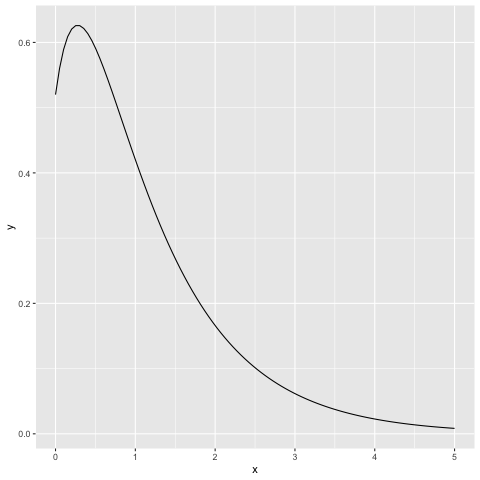

In [5]:
%%R -i t_2 -i N_AB -i n_int_ABC_2 -o quant

library(PhaseTypeR)
library(tidyverse)

subint_mat <- matrix(
    c(
        c(-1, 0, 0),
        c(0, -3, 3),
        c(0, 0, -1)
    ),
    nrow = 3,
    byrow = T
)
init_probs <- c(1-exp(-t_2/N_AB), exp(-t_2/N_AB), 0)
ph_obj <- PH(subint_mat, init_probs)

quant <- qPH(seq(0, 1, length.out = n_int_ABC_2+1), ph_obj)
quant <- c(quant[1:(length(quant)-1)], Inf)

x <- seq(0, 5, length.out = 100)
y <- dPH(x, ph_obj)
ggplot() +
    geom_line(aes(x, y))

In [6]:
t_1+t_2+cutpoints_ABC(n_int_ABC_2, coal_ABC)*N_ref

array([258717.53400642, 269508.08159432, 282270.5905699 , 297890.6391619 ,
       318028.38423352, 346410.94180109, 394931.24444029,             inf])

In [7]:
cut_ABC = t_1+t_2+quant*N_ABC
cut_ABC

array([258717.53400642, 275680.38719023, 291866.09530467, 309719.93419909,
       331364.74879218, 360730.39159387, 409808.60128951,             inf])

In [8]:
transitions, emissions, starting, hidden_states, observed_states = trans_emiss_calc(
    t_A*mu, t_B*mu, t_C*mu, t_2*mu, t_upper*mu, t_out*mu, 
    N_AB*mu, N_ABC*mu, r/mu, n_int_AB, n_int_ABC_2,
    cut_AB = 'standard', cut_ABC = quant
)

/Users/au595587/opt/miniconda3/envs/phasetype/lib/python3.8/site-packages/trails/get_joint_prob_mat.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if cut_ABC == 'standard':
2023-05-01 14:50:13,694	INFO worker.py:1518 -- Started a local Ray instance.
(PoolActor pid=91715) E0501 14:54:40.310601000 123145355927552 chttp2_transport.cc:1103]     Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(PoolActor pid=91716) E0501 14:54:40.314975000 123145344348160 chttp2_transport.cc:1103]     Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(PoolActor pid=91719) E0501 14:54:40.317386000 123145559887872 chttp2_transport.cc:1103]     Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
/Users/au595587/opt/miniconda3/envs/phasetype/lib/python3.8/site-packages/trails/get_emission_prob_mat.

In [9]:
dct_hid = {v: k for k, v in hidden_states.items()}
dct = {v: k for k, v in observed_states.items()}

In [10]:
####################### Add demography #######################

n_sites = 100_000

demography = msprime.Demography()
demography.add_population(name="A", initial_size=N_AB, default_sampling_time=t_1-t_A)
demography.add_population(name="B", initial_size=N_AB, default_sampling_time=t_1-t_B)
demography.add_population(name="C", initial_size=N_AB, default_sampling_time=t_1-t_C)
demography.add_population(name="D", initial_size=N_AB, default_sampling_time=t_1-t_1)
demography.add_population(name="AB", initial_size=N_AB)
demography.add_population(name="ABC", initial_size=N_ABC)
demography.add_population(name="ABCD", initial_size=N_ABC)
demography.add_population_split(time=t_1, derived=["A", "B"], ancestral="AB")
demography.add_population_split(time=t_1+t_2, derived=["AB", "C"], ancestral="ABC")
demography.add_population_split(time=t_1+t_2+t_3, derived=["ABC", "D"], ancestral="ABCD")

ts = msprime.sim_ancestry(
    {"A": 1, "B": 1, "C": 1,
     "D": 1
    },
    demography=demography,
    recombination_rate=r,
    sequence_length=n_sites,
    ploidy=1,
    random_seed=seed
)


In [11]:
#### Add mutations

mutated_ts = msprime.sim_mutations(ts, rate=mu, random_seed=seed)

nochange_lst = [dct['AAAA'], dct['CCCC'], dct['TTTT'], dct['GGGG']]
np.random.seed(seed) ; sim_genome = np.random.choice(nochange_lst, n_sites)

mut_lst = []
mut_loc = []
for variant in mutated_ts.variants():
    mut_loc.append(variant.site.position)
    mut_lst.append(''.join([variant.alleles[i] for i in variant.genotypes]))

for i in range(len(mut_loc)):
    sim_genome[int(mut_loc[i])] = dct[mut_lst[i]]


In [12]:
post = post_prob_wrapper(transitions, emissions, starting, [sim_genome])[0]

In [13]:
hidden_matrix = np.random.randint(max([n_int_AB, n_int_ABC_2]), size=(len(dct_hid), 4))
hidden_matrix[:,0] = list(range(len(dct_hid)))
hidden_matrix[:,1] = [i[0] for i in dct_hid.keys()]
hidden_matrix[:,2] = [i[1] for i in dct_hid.keys()]
hidden_matrix[:,3] = [i[2] for i in dct_hid.keys()]

In [14]:
left_lst = []
right_lst = []
tree_state = []
t_AB_vec = []
t_ABC_vec = []
for t in ts.trees():
    # Append start coordinate
    left_lst.append(t.interval.left)
    # Append end coordinate
    right_lst.append(t.interval.right-1)
    # Get all non-zero coalescent times
    ntimes = [ts.nodes()[n].time for n in t.nodes() if ts.nodes()[n].time not in [0, t_1-t_A, t_1-t_B, t_1-t_C]]
    ntimes = sorted(ntimes)
    # Get time of the first event
    mint = ntimes[0]
    mint2 = ntimes[1]
    # Find topology
    find_re = re.findall("n\d,n\d", t.as_newick(include_branch_lengths=False))[0]
    # Sort species within topology
    find_re = sorted(find_re.split(','))
    # If V0 or V1
    if find_re == ['n0', 'n1']:
        # If the time of the first coalescent is larger than the deepest speciation event
        if mint>=(t_1+t_2):
            state = (1, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
            # Append V1 state
        else:
            state = (0, (mint>cut_AB).sum()-1, (mint2>cut_ABC).sum()-1)
            # Append V0 state
    # If V2
    elif find_re == ['n0', 'n2']:
        state = (2, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    # If V3
    elif find_re == ['n1', 'n2']:
        state = (3, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    else:
        state = (4, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    tree_state.append(state)
    t_AB_vec.append(mint)
    t_ABC_vec.append(mint2)


In [15]:
tree_matrix = np.random.randint(max(left_lst), size=(len(left_lst), 3))
tree_matrix[:,0] = left_lst
tree_matrix[:,1] = right_lst
tree_matrix[:,2] = [dct_hid[i] for i in tree_state]

In [16]:
%%R -i post -i hidden_matrix -i tree_matrix

library(tidyverse)

hid_tab <- as_tibble(hidden_matrix) %>%
    rename(name = V1, topology = V2, int_1 = V3, int_2 = V4)
    
write_csv(hid_tab, '../data/hid_tab.csv')
    
tree_tab <- as_tibble(tree_matrix) %>%
    rename(start = V1, end = V2, name = V3) %>%
    mutate(
        gr = ifelse(lag(name) != name, 1, 0) %>% coalesce(0),
        gr = cumsum(gr) + 1
    ) %>% 
    group_by(gr, name) %>%
    summarize(start = min(start), end = max(end)) %>%
    left_join(hid_tab, by = 'name')
    
write_csv(tree_tab, '../data/tree_tab.csv')

post_tab <- as_tibble(post) %>%
    mutate(pos = 0:(n()-1)) %>%
    pivot_longer(-pos) %>%
    mutate(name = as.integer(str_remove_all(name, 'V'))-1) %>%
    left_join(hid_tab, by = 'name')
     
write_csv(post_tab, '../data/post_tab.csv')

`summarise()` has grouped output by 'gr'. You can override using the `.groups` argument.


## Modified cutpoints (first coalescent)

The first coalescent event, when happening deep in time and not between the speciation events, follows an exponential with rate 3, because three lineages will be segregating together. Since the original cutpoint scheme uses exponential with rate 1, most of the coalescents will happen in earlier intervals. In order to perform posterior decoding in a better way for the first coalescent, the cutpoints of the 

In [17]:
t_out = t_1+t_2+t_3+2*N_ABC

N_ref = N_ABC

coal_ABC = N_ref/N_ABC
coal_AB = N_ref/N_AB
t_upper = t_3-cutpoints_ABC(n_int_ABC_1, coal_ABC)[-2]*N_ref
t_AB = t_2/N_ref

cut_AB = t_1+cutpoints_AB(n_int_AB, t_AB, coal_AB)*N_ref
# cut_ABC = t_1+t_2+cutpoints_ABC(n_int_ABC_1, coal_ABC)*N_ref
cut_ABC_new = cutpoints_ABC(n_int_ABC_1, 3)
cut_ABC = t_1+t_2+cut_ABC_new*N_ref

(2/3)*(np.exp(-t_2/(N_AB)))

0.31999999999999995

In [18]:
N_AB

80000

In [19]:
cut_AB

array([200000.        , 208785.18928058, 218655.51097342, 229917.3152839 ,
       243028.34369231, 258717.53400642])

In [20]:
cut_ABC

array([258717.53400642, 265430.11569696, 274890.96821948, 291064.40243255,
                   inf])

In [21]:
transitions, emissions, starting, hidden_states, observed_states = trans_emiss_calc(
    t_A*mu, t_B*mu, t_C*mu, t_2*mu, t_upper*mu, t_out*mu, 
    N_AB*mu, N_ABC*mu, r/mu, n_int_AB, n_int_ABC_1,
    cut_AB = 'standard', cut_ABC = cut_ABC_new
)

/Users/au595587/opt/miniconda3/envs/phasetype/lib/python3.8/site-packages/trails/get_joint_prob_mat.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if cut_ABC == 'standard':
/Users/au595587/opt/miniconda3/envs/phasetype/lib/python3.8/site-packages/trails/get_emission_prob_mat.py:632: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if cut_ABC == 'standard':


In [22]:
dct_hid = {v: k for k, v in hidden_states.items()}
dct = {v: k for k, v in observed_states.items()}

In [23]:
####################### Add demography #######################

n_sites = 100_000

demography = msprime.Demography()
demography.add_population(name="A", initial_size=N_AB, default_sampling_time=t_1-t_A)
demography.add_population(name="B", initial_size=N_AB, default_sampling_time=t_1-t_B)
demography.add_population(name="C", initial_size=N_AB, default_sampling_time=t_1-t_C)
demography.add_population(name="D", initial_size=N_AB, default_sampling_time=t_1-t_1)
demography.add_population(name="AB", initial_size=N_AB)
demography.add_population(name="ABC", initial_size=N_ABC)
demography.add_population(name="ABCD", initial_size=N_ABC)
demography.add_population_split(time=t_1, derived=["A", "B"], ancestral="AB")
demography.add_population_split(time=t_1+t_2, derived=["AB", "C"], ancestral="ABC")
demography.add_population_split(time=t_1+t_2+t_3, derived=["ABC", "D"], ancestral="ABCD")

ts = msprime.sim_ancestry(
    {"A": 1, "B": 1, "C": 1,
     "D": 1
    },
    demography=demography,
    recombination_rate=r,
    sequence_length=n_sites,
    ploidy=1,
    random_seed=seed
)


In [24]:
#### Add mutations

mutated_ts = msprime.sim_mutations(ts, rate=mu, random_seed=seed)

nochange_lst = [dct['AAAA'], dct['CCCC'], dct['TTTT'], dct['GGGG']]
np.random.seed(seed) ; sim_genome = np.random.choice(nochange_lst, n_sites)

mut_lst = []
mut_loc = []
for variant in mutated_ts.variants():
    mut_loc.append(variant.site.position)
    mut_lst.append(''.join([variant.alleles[i] for i in variant.genotypes]))

for i in range(len(mut_loc)):
    sim_genome[int(mut_loc[i])] = dct[mut_lst[i]]


In [25]:
post = post_prob_wrapper(transitions, emissions, starting, [sim_genome])[0]

In [26]:
hidden_matrix = np.random.randint(max([n_int_AB, n_int_ABC_1]), size=(len(dct_hid), 4))
hidden_matrix[:,0] = list(range(len(dct_hid)))
hidden_matrix[:,1] = [i[0] for i in dct_hid.keys()]
hidden_matrix[:,2] = [i[1] for i in dct_hid.keys()]
hidden_matrix[:,3] = [i[2] for i in dct_hid.keys()]

In [27]:
left_lst = []
right_lst = []
tree_state = []
t_AB_vec = []
t_ABC_vec = []
for t in ts.trees():
    # Append start coordinate
    left_lst.append(t.interval.left)
    # Append end coordinate
    right_lst.append(t.interval.right-1)
    # Get all non-zero coalescent times
    ntimes = [ts.nodes()[n].time for n in t.nodes() if ts.nodes()[n].time not in [0, t_1-t_A, t_1-t_B, t_1-t_C]]
    ntimes = sorted(ntimes)
    # Get time of the first event
    mint = ntimes[0]
    mint2 = ntimes[1]
    # Find topology
    find_re = re.findall("n\d,n\d", t.as_newick(include_branch_lengths=False))[0]
    # Sort species within topology
    find_re = sorted(find_re.split(','))
    # If V0 or V1
    if find_re == ['n0', 'n1']:
        # If the time of the first coalescent is larger than the deepest speciation event
        if mint>=(t_1+t_2):
            state = (1, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
            # Append V1 state
        else:
            state = (0, (mint>cut_AB).sum()-1, (mint2>cut_ABC).sum()-1)
            # Append V0 state
    # If V2
    elif find_re == ['n0', 'n2']:
        state = (2, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    # If V3
    elif find_re == ['n1', 'n2']:
        state = (3, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    else:
        state = (4, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    tree_state.append(state)
    t_AB_vec.append(mint)
    t_ABC_vec.append(mint2)


In [28]:
tree_matrix = np.random.randint(max(left_lst), size=(len(left_lst), 3))
tree_matrix[:,0] = left_lst
tree_matrix[:,1] = right_lst
tree_matrix[:,2] = [dct_hid[i] for i in tree_state]

In [29]:
%%R -i post -i hidden_matrix -i tree_matrix

library(tidyverse)

hid_tab <- as_tibble(hidden_matrix) %>%
    rename(name = V1, topology = V2, int_1 = V3, int_2 = V4)
    
write_csv(hid_tab, '../data/hid_tab_cutpoints.csv')
    
tree_tab <- as_tibble(tree_matrix) %>%
    rename(start = V1, end = V2, name = V3) %>%
    mutate(
        gr = ifelse(lag(name) != name, 1, 0) %>% coalesce(0),
        gr = cumsum(gr) + 1
    ) %>% 
    group_by(gr, name) %>%
    summarize(start = min(start), end = max(end)) %>%
    left_join(hid_tab, by = 'name')
    
write_csv(tree_tab, '../data/tree_tab_cutpoints.csv')

post_tab <- as_tibble(post) %>%
    mutate(pos = 0:(n()-1)) %>%
    pivot_longer(-pos) %>%
    mutate(name = as.integer(str_remove_all(name, 'V'))-1) %>%
    left_join(hid_tab, by = 'name')
     
write_csv(post_tab, '../data/post_tab_cutpoints.csv')

`summarise()` has grouped output by 'gr'. You can override using the `.groups` argument.


In [30]:
%%R

post_tab %>%
    group_by(pos) %>%
    summarize(s = sum(value))

# A tibble: 100,000 × 2
     pos     s
   <int> <dbl>
 1     0     1
 2     1     1
 3     2     1
 4     3     1
 5     4     1
 6     5     1
 7     6     1
 8     7     1
 9     8     1
10     9     1
# … with 99,990 more rows
